In [1]:
import os
import warnings
import tqdm
import pandas as pd
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [2]:
%load_ext autoreload
%autoreload 2
import socceraction.spadl as spadl
import socceraction.vaep.formula as vaepformula

## Select data

In [3]:
# Configure file and folder names
datafolder = "../Data/wyscout-v2"
spadl_h5 = os.path.join(datafolder, "spadl-wyscout-v2.h5")
predictions_h5 = os.path.join(datafolder, "predictions.h5")

In [4]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    players = spadlstore["players"]
    teams = spadlstore["teams"]
print("nb of games:", len(games))

nb of games: 380


## Compute VAEP values

In [5]:
A = []
for game in tqdm.tqdm(list(games.itertuples()), desc="Rating actions"):
    actions = pd.read_hdf(spadl_h5, f"actions/game_{game.game_id}")
    actions = (
        spadl.add_names(actions)
        .merge(players, how="left")
        .merge(teams, how="left")
        .sort_values(["game_id", "period_id", "action_id"])
        .reset_index(drop=True)
    )
    preds = pd.read_hdf(predictions_h5, f"game_{game.game_id}")
    values = vaepformula.value(actions, preds.scores, preds.concedes)
    A.append(pd.concat([actions, preds, values], axis=1))
A = pd.concat(A).sort_values(["game_id", "period_id", "time_seconds"]).reset_index(drop=True)
A.columns

Rating actions: 100%|██████████| 380/380 [00:11<00:00, 33.72it/s]


Index(['game_id', 'period_id', 'time_seconds', 'team_id', 'player_id',
       'start_x', 'start_y', 'end_x', 'end_y', 'original_event_id',
       'bodypart_id', 'type_id', 'result_id', 'action_id', 'type_name',
       'result_name', 'bodypart_name', 'player_name', 'nickname',
       'team_name_short', 'team_name', 'scores', 'concedes', 'offensive_value',
       'defensive_value', 'vaep_value'],
      dtype='object')

## Analyse VAEP ratings
### Most valuable players

In [6]:
A["count"] = 1

# Compute each player's number of actions and total VAEP values
playersR = (
    A[["player_id", "vaep_value", "offensive_value", "defensive_value", "count"]]
    .groupby(["player_id"])
    .sum()
    .reset_index()
)
# Add player names
playersR = playersR.merge(players[["player_id", "nickname", "player_name"]], how="left")
playersR["player_name"] = playersR[["nickname","player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
# Show results
playersR = playersR[["player_id", "player_name", "vaep_value", "offensive_value", "defensive_value", "count"]]
playersR.sort_values("vaep_value", ascending=False)[:10]

,player_id,player_name,vaep_value,offensive_value,defensive_value,count
392,120353,Mohamed Salah,27.403303,27.557314,-0.154011,1568
185,8717,H. Kane,19.519514,19.931237,-0.411722,1147
313,26150,R. Mahrez,17.838054,18.054849,-0.216795,2018
325,38021,K. De Bruyne,16.926032,17.322192,-0.396160,3523
300,25707,E. Hazard,16.007881,16.009173,-0.001292,1970
4,54,C. Eriksen,15.512157,15.890605,-0.378448,2956
333,49872,X. Shaqiri,13.617732,13.682395,-0.064662,1715
140,8317,David Silva,13.360364,13.204618,0.155746,2923
143,8325,S. Agüero,12.980581,13.050766,-0.070185,977
388,105339,Fernandinho,12.907502,11.988033,0.919469,3410


In [7]:
# Normalize for minutes played
pg = pd.read_hdf(spadl_h5, "player_games")
pg = pg[pg.game_id.isin(games.game_id)]
mp = pg[["player_id", "minutes_played"]].groupby("player_id").sum().reset_index()

stats = playersR.merge(mp)
stats = stats[stats.minutes_played > 180] # at least two full games played
stats["vaep_rating"] = stats.vaep_value * 90 / stats.minutes_played
stats["offensive_rating"] = stats.offensive_value * 90 / stats.minutes_played
stats["defensive_rating"] = stats.defensive_value * 90 / stats.minutes_played
stats.sort_values("vaep_rating",ascending=False)[:10]

,player_id,player_name,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,offensive_rating,defensive_rating
391,120353,Mohamed Salah,27.403303,27.557314,-0.154011,1568,3065,0.804665,0.809187,-0.004522
48,3802,Philippe Coutinho,8.820224,9.184711,-0.364486,1014,1159,0.684918,0.713222,-0.028303
299,25707,E. Hazard,16.007881,16.009173,-0.001292,1970,2551,0.564763,0.564808,-0.000046
141,8324,Y. Touré,1.638087,1.641343,-0.003256,466,263,0.560562,0.561676,-0.001114
142,8325,S. Agüero,12.980581,13.050766,-0.070185,977,2096,0.557372,0.560386,-0.003014
184,8717,H. Kane,19.519514,19.931237,-0.411722,1147,3257,0.539379,0.550756,-0.011377
312,26150,R. Mahrez,17.838054,18.054849,-0.216795,2018,3127,0.513407,0.519647,-0.006240
398,134513,A. Martial,9.393998,9.499640,-0.105642,1107,1684,0.502055,0.507700,-0.005646
306,25867,P. Aubameyang,6.236711,6.366224,-0.129513,436,1121,0.500717,0.511115,-0.010398
445,274488,J. Lolley,1.323686,1.336240,-0.012555,106,242,0.492280,0.496949,-0.004669


### (optional) inspect Arsenal's top 10 most valuable non-shot actions

2017-12-02 17:30:00 Arsenal FC vs Manchester United FC 33' interception Sead Kolašinac


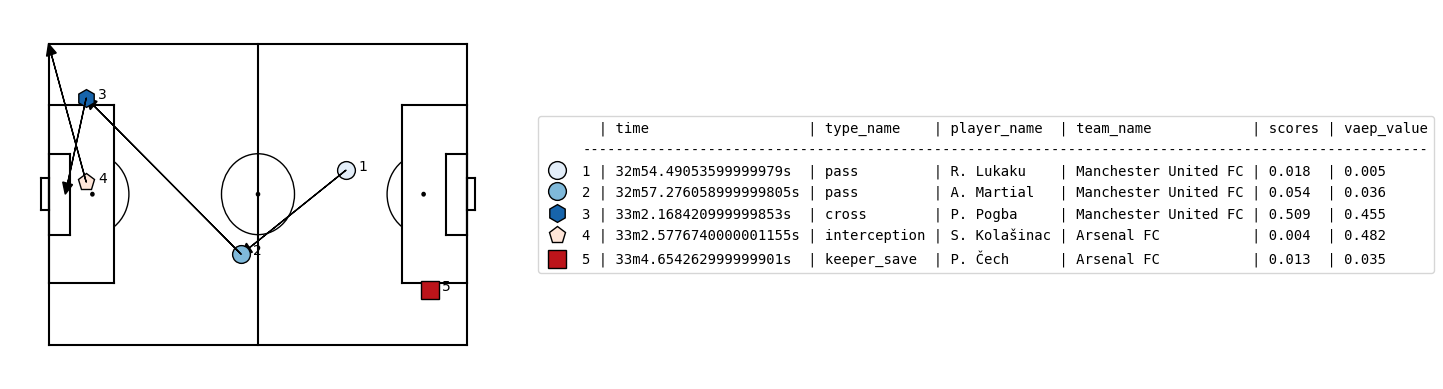

2018-04-08 13:15:00 Arsenal FC vs Southampton FC 77' pass Jack Wilshere


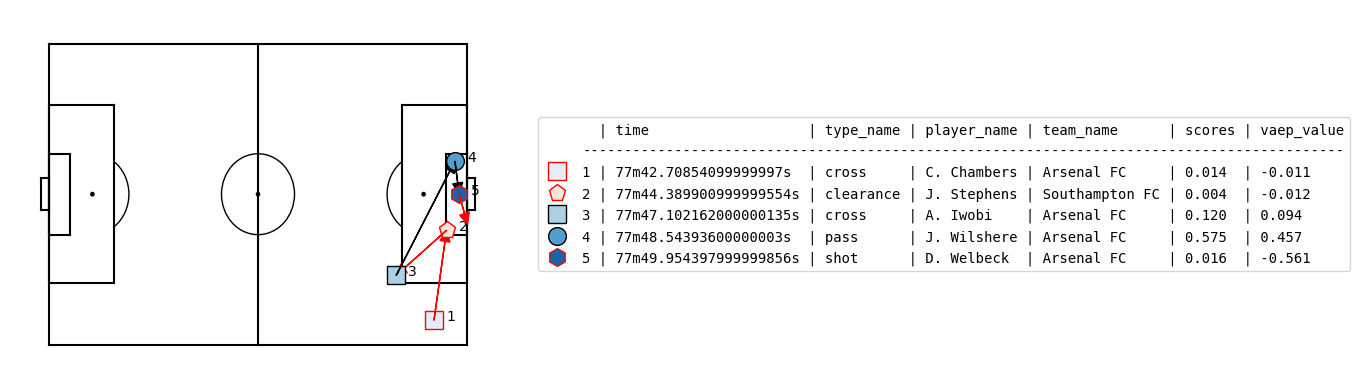

2018-01-20 15:00:00 Arsenal FC vs Crystal Palace FC 12' cross Ignacio Monreal Eraso


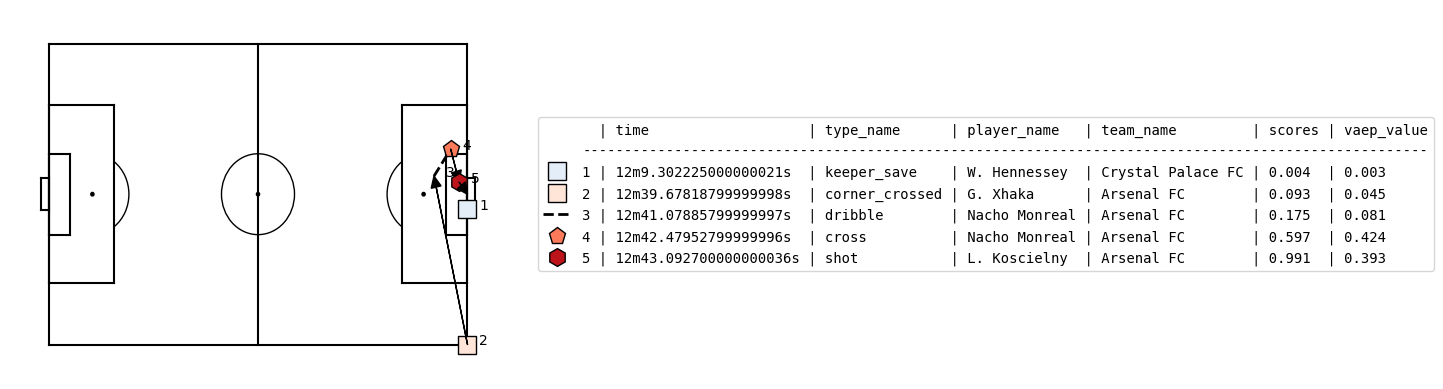

2017-12-02 17:30:00 Arsenal FC vs Manchester United FC 19' pass Granit Xhaka


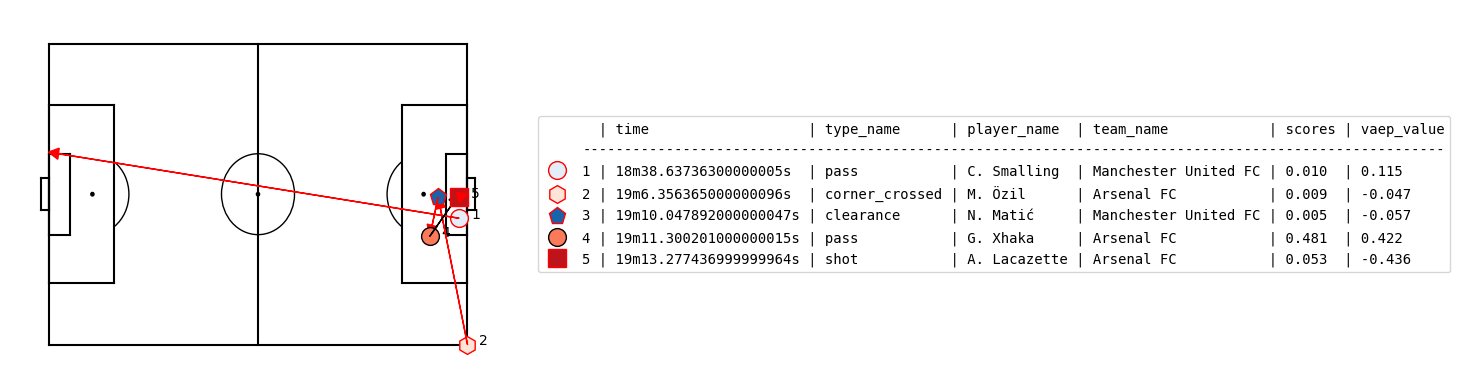

2018-05-13 14:00:00 Huddersfield Town FC vs Arsenal FC 37' cross Aaron Ramsey


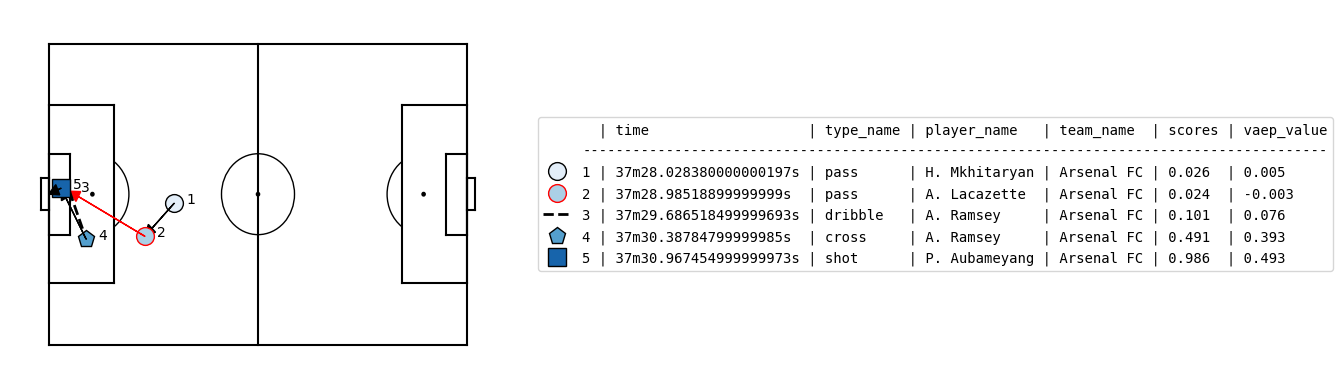

2018-05-06 15:30:00 Arsenal FC vs Burnley FC 13' cross Alexandre Lacazette


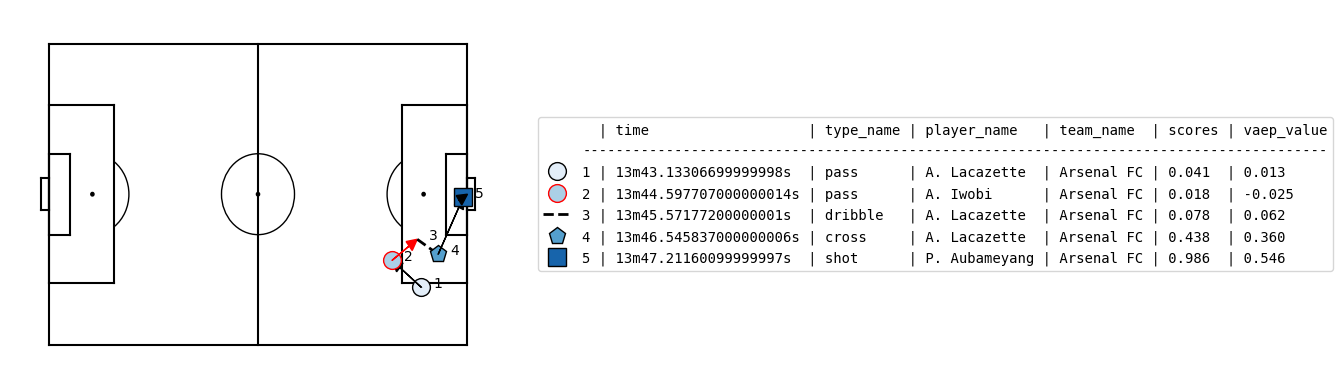

2017-10-22 12:30:00 Everton FC vs Arsenal FC 83' dribble Aaron Ramsey


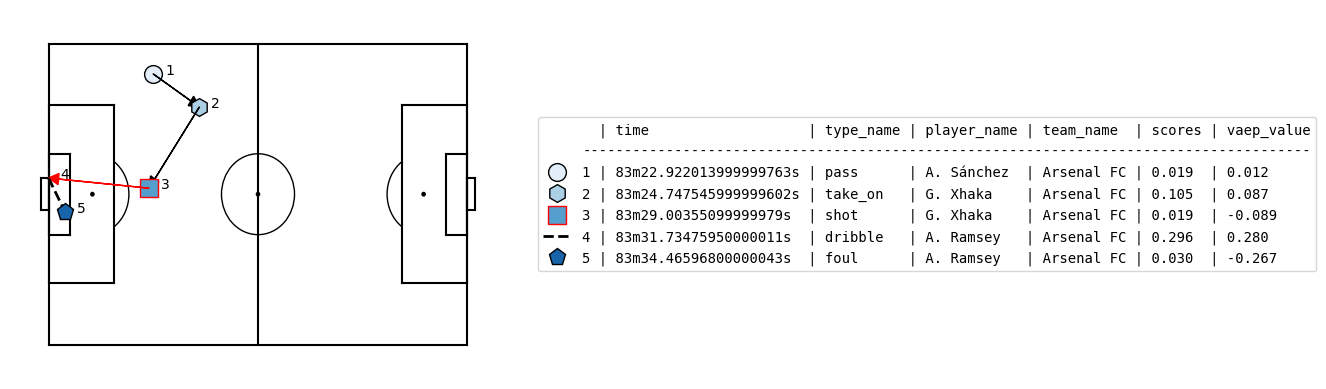

2017-11-18 12:30:00 Arsenal FC vs Tottenham Hotspur FC 40' cross Alexandre Lacazette


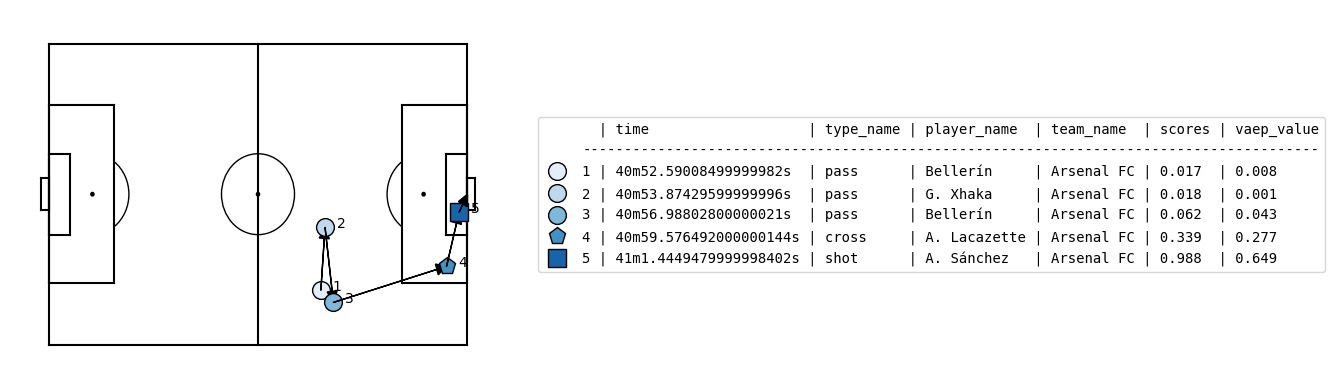

2017-12-10 12:00:00 Southampton FC vs Arsenal FC 28' keeper_save Petr Čech


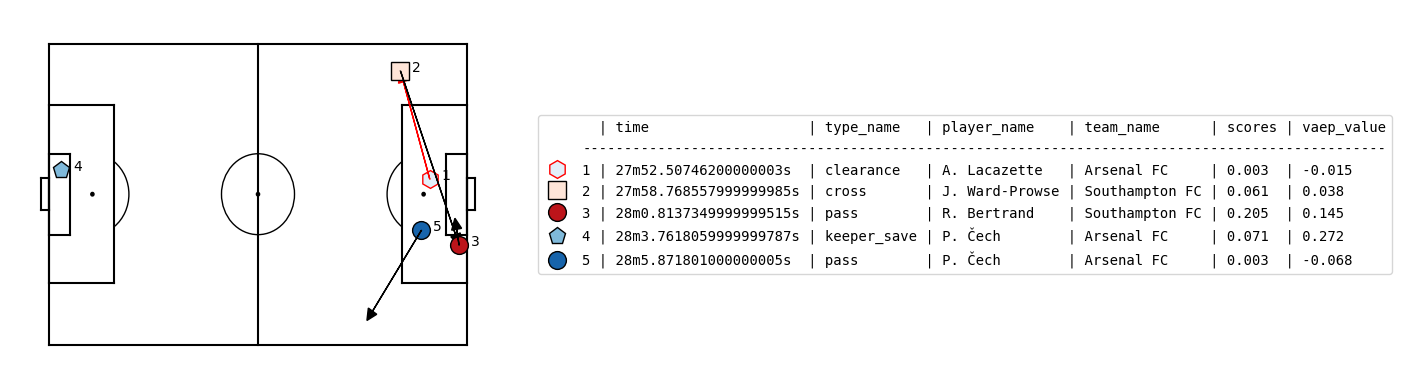

2018-04-08 13:15:00 Arsenal FC vs Southampton FC 81' cross Alex Iwobi


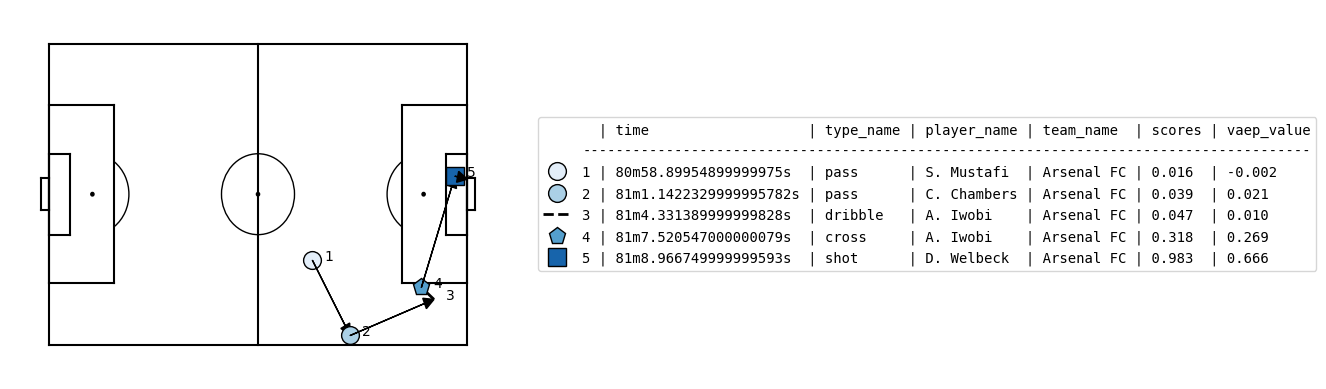

In [10]:
import matplotsoccer

sorted_A = A.sort_values("vaep_value", ascending=False)
sorted_A = sorted_A[sorted_A.team_name == "Arsenal FC"] # view only actions from Belgium
sorted_A = sorted_A[~sorted_A.type_name.str.contains("shot")] #eliminate shots

def get_time(period_id,time_seconds):
    m = int((period_id-1)*45 + time_seconds // 60)
    s = time_seconds % 60
    if s == int(s):
        s = int(s)
    return f"{m}m{s}s"

for j in range(0, 10):
    row = list(sorted_A[j:j+1].itertuples())[0]
    i = row.Index
    a = A[i - 3 : i+2].copy()
    
    a["player_name"] = a[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
    
    g = list(games[games.game_id == a.game_id.values[0]].itertuples())[0]
    game_info = f"{g.game_date} {g.home_team_name} vs {g.away_team_name}"
    minute = int((row.period_id-1)*45 + row.time_seconds // 60)
    print(f"{game_info} {minute}' {row.type_name} {row.player_name}")

    a["scores"] = a.scores.apply(lambda x : "%.3f" % x )
    a["vaep_value"] = a.vaep_value.apply(lambda x : "%.3f" % x )
    a["time"] = a[["period_id","time_seconds"]].apply(lambda x: get_time(*x),axis=1)
    cols = ["time", "type_name", "player_name", "team_name", "scores", "vaep_value"]
    matplotsoccer.actions(a[["start_x","start_y","end_x","end_y"]],
                a.type_name,
                team=a.team_name,
                result = a.result_name == "success",
                label=a[cols],
                labeltitle = cols,
                zoom=False)